In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys
sys.path.insert(0, '../')
from scipy import misc
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers import LocallyConnected2D
from keras.layers.convolutional import Conv2D
from keras.layers import *
from keras import Model
from keras import optimizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,TensorBoard, Callback
import matplotlib.pyplot as plt
%matplotlib nbagg
from keras.utils import np_utils
from keras import backend as K
import cv2
from common import util
from sklearn.model_selection import train_test_split
import random
import glob
import tensorflow as tf
K.set_image_dim_ordering('th')

/usr/local/lib/python2.7/dist-packages/dlutils/plot_image_batch_w_labels.py:16: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/

In [304]:
def hot_vectorize(x,value = 0):
    zero_mask = x==value
    non_zero_mask = x!=value
    x[zero_mask] = 1
    x[non_zero_mask] = 0
    return x.astype(float)

def stack_frames(frames,img_height,img_width,channels):
    stack  = np.zeros((1,img_height,img_width,channels))
    index = 0
    for i in frames:
        num_chan = 1 if len(np.shape(i)) ==2 else np.shape(i)[2]
        stack[0,:,:,index:index+num_chan] = np.reshape(i,(img_height,img_width,num_chan))
        index += num_chan
    return stack

def grab_frame(files,i,path,func=None):
    img = misc.imread(path+files[i])
    if func:
        return func(img)
    return img

def grab_frame1(path,func=None):
    img = misc.imread(path)
    if func:
        return func(img)
    return img

def normalize(x):
    return x.astype(float)/3500.

def normalize_depth(x):
    return x.astype(float)/3000.

def convert_rgb_normal(img):
    return (img/255.*2)-1

def bounding_box(img,size = 100):
    h,w = np.shape(img)
    non_zeros = np.nonzero(img)
    x_min = np.min(non_zeros[0])
    x_max = np.max(non_zeros[0])
    y_min = np.min(non_zeros[1])
    y_max = np.max(non_zeros[1])
    out = (x_min,x_min+size,y_min,y_min+size) if size else (x_min,x_max,y_min,y_max)#minuce or plus coordinates
    if x_min< 0 or x_min+size > h or y_min<0 or y_min+size>w:
        return None
    return out

def crop(x,x1 = 100,x2 = 500,y1 = 50, y2 = 450):
    x = x[y1:y2,x1:x2]
    return x
def flip_vert(x,y):
    y= np.flip(y,axis=0)
    x= np.flip(x,axis=0)
    return x,y
def flip_hor(x,y):
    x= np.flip(x,axis=1)
    y= np.flip(y,axis=1)
    return x,y
def rotate(x,y):
    degrees = np.random.randint(360)
    centerx = tuple(np.array(x.shape[1::-1]) / 2)
    centery = tuple(np.array(y.shape[1::-1]) / 2)
    rotx = cv2.getRotationMatrix2D(centerx, degrees, 1.0)
    roty = cv2.getRotationMatrix2D(centery, degrees, 1.0)
    x = cv2.warpAffine(x, rotx, x.shape[1::-1], flags=cv2.INTER_LINEAR)
    y = cv2.warpAffine(y, roty, y.shape[1::-1], flags=cv2.INTER_LINEAR)
    return x,y
def augment(x,y,func = [],bias_to_real = .5):
    #x = crop(x)
   # y = crop(y)
    if np.random.rand()>bias_to_real:#bias to real images
        function = np.random.choice(func)
        x,y=function(x,y)
    return x,y


In [324]:
def cross_validate(samples,ways):
    samples = np.copy(samples)
    random.shuffle(samples)
    tests = np.array_split(samples,ways)
    return tests
def grab_test_train(tests,i):
    tests = np.copy(tests)
    test = list(tests).pop(i)
    train = np.concatenate(tests)
    return (train,test)
    

In [335]:
val = cross_validate(samples,10)
train, test = grab_test_train(val,0)

In [183]:
len(train), len(test)

(227737, 22774)

In [19]:
samples = gen_samples("/media/drc/DATA/chris_labelfusion/RGBDCNN/")

In [326]:
train = generate_data_custom_depth(train,func=[flip_hor,flip_vert,rotate],img_height=480,img_width=640)

In [12]:
def gen_samples(directory,shuffle = True):
    samples = []
    dirs = os.listdir(directory)
    for i in dirs:
        path = os.path.join(directory, i)+"/"
        if os.access(path, os.R_OK):
            gt_depth = sorted(glob.glob(path+"*_truth.png"))
            depth = sorted(glob.glob(path+"*_depth.png"))
            samples.extend(zip(gt_depth,depth))
    if shuffle:
        random.shuffle(samples)
    return samples                

In [13]:
def generate_data_custom_depth(samples,img_height=480,img_width=640,batch_size=4,func=[]):
    i = 0
    while True:
        stack1 = np.zeros((batch_size,img_height,img_width,1))
        stack2 = np.zeros((batch_size,img_height,img_width,1))
        j=0
        while j<batch_size:
            try: 
                rgb = samples[i][0]
                depth = samples[i][1]
                rgb_img = grab_frame1(rgb,normalize)
                depth_img = grab_frame1(depth,hot_vectorize)
                rgb_img,depth_img = augment(rgb_img,depth_img,func,bias_to_real = .5)
                stack1[j] = np.reshape(rgb_img,(img_height,img_width,1))
                stack2[j] = np.reshape(depth_img,(img_height,img_width,1))
                j+=1
                i= (i+1)%len(samples)
            except Exception:
                i=(i+1)%len(samples)
        yield (stack1,stack2)

In [14]:
def generate_data_custom1(depth_as_mask=True,img_height=480,img_width=640,batch_size=4,path="/media/drc/DATA/CNN/",dir_name = "test/",filter_files = None,func=None):

    rgb_path = path+"rgb/"
    depth_path = path+"depth/"

    rgb = np.sort(os.listdir(rgb_path))
    depth = np.sort(os.listdir(depth_path))

    if filter_files:
            rgb = np.sort(filter(lambda x: filter_files in x, rgb))
            depth = np.sort(filter(lambda x: filter_files in x, depth))

    i = -1
    while True:
        stack1 = np.zeros((batch_size,img_height,img_width,3))
        stack2 = np.zeros((batch_size,img_height,img_width,1))

        for j in range(batch_size):
            i= (i+1)%len(rgb)
            rgb_img = grab_frame(rgb,i,rgb_path,func)
          
            depth_img = grab_frame(depth,i,depth_path,hot_vectorize)
            stack = stack_frames([rgb_img],img_height,img_width,3)
            stack1[j] = stack
            stack2[j] = np.reshape(depth_img,(img_height,img_width,1))
        yield (stack1,stack2)

In [15]:
def generate_data_custom3(depth_as_mask=True,img_height=480,img_width=640,batch_size=8,path="/media/drc/DATA/CNN/",dir_name = "test/",filter_files = None,func=None):

    rgb_path = path+"rgb/"+"rgb/"
    depth_path = path+"depth/"+ "depth/"
    gtdepth_path = path+"gtdepth/" + "gtdepth/"
    normal_path = path+"normal/" + "normal/"

    rgb = np.sort(os.listdir(rgb_path))
    normal = np.sort(os.listdir(normal_path))
    depth = np.sort(os.listdir(depth_path))
    gtdepth = np.sort(os.listdir(gtdepth_path))

    if filter_files:
            rgb = np.sort(filter(lambda x: filter_files in x, rgb))
            normal = np.sort(filter(lambda x: filter_files in x, normal))
            depth = np.sort(filter(lambda x: filter_files in x, depth))
            gtdepth = np.sort(filter(lambda x: filter_files in x, gtdepth))

    i = -1
    while True:
        stack1 = np.zeros((batch_size,img_height,img_width,7))
        stack2 = np.zeros((batch_size,img_height,img_width,1))

        for j in range(batch_size):
            i= (i+1)%len(depth)
            rgb_img = grab_frame(rgb,i,rgb_path,func)
            normal_img = grab_frame(normal,i,normal_path,normalize)
            gtdepth_img = grab_frame(gtdepth,i,gtdepth_path,normalize_depth)
            depth_img = grab_frame(depth,i,depth_path,hot_vectorize)
            gtdepth_img[gtdepth_img==0]=1.

            stack = stack_frames([gtdepth_img,normal_img,rgb_img],img_height,img_width,7)
            stack1[j] = stack
            stack2[j] = np.reshape(depth_img,(img_height,img_width,1))
        yield (stack1,stack2)

In [16]:
def generate_data_custom(depth_as_mask=True,img_height=480,img_width=640,batch_size=8,channels =1,path="/media/drc/DATA/CNN/",dir_name = "test/",filter_files = None,func=None):

    rgb_path = path+"rgb/"+"rgb/"
    depth_path = path+"depth/"+ "depth/"
    gtdepth_path = path+"gtdepth/" + "gtdepth/"
    normal_path = path+"normal/" + "normal/"

    rgb = np.sort(os.listdir(rgb_path))
    normal = np.sort(os.listdir(normal_path))
    depth = np.sort(os.listdir(depth_path))
    gtdepth = np.sort(os.listdir(gtdepth_path))

    if filter_files:
            rgb = np.sort(filter(lambda x: filter_files in x, rgb))
            normal = np.sort(filter(lambda x: filter_files in x, normal))
            depth = np.sort(filter(lambda x: filter_files in x, depth))
            gtdepth = np.sort(filter(lambda x: filter_files in x, gtdepth))

    i = -1
    while True:
        stack1 = np.zeros((batch_size,img_height,img_width,channels))
        stack2 = np.zeros((batch_size,img_height,img_width,1))

        for j in range(batch_size):
            i= (i+1)%len(depth)
            rgb_img = grab_frame(rgb,i,rgb_path,func)
            normal_img = grab_frame(normal,i,normal_path,normalize)
            gtdepth_img = grab_frame(gtdepth,i,gtdepth_path,normalize_depth)
            depth_img = grab_frame(depth,i,depth_path,hot_vectorize)
            a = bounding_box(gtdepth_img,img_height)
            while not a:
                i= (i+1)%len(depth)
                rgb_img = grab_frame(rgb,i,rgb_path,func)
                normal_img = grab_frame(normal,i,normal_path,normalize)
                gtdepth_img = grab_frame(gtdepth,i,gtdepth_path,normalize_depth)
                depth_img = grab_frame(depth,i,depth_path,hot_vectorize)
                a = bounding_box(gtdepth_img,img_height)

            x1,x2,y1,y2 = a
            depth_img = depth_img[x1:x2,y1:y2] 
            gtdepth_img = gtdepth_img[x1:x2,y1:y2]
            normal_img = normal_img[x1:x2,y1:y2]
            gtdepth_img[gtdepth_img==0]=1.

            #stack = stack_frames([gtdepth_img,normal_img,rgb_img],img_height,img_width,4)
            stack = stack_frames([gtdepth_img],img_height,img_width,channels)

            stack1[j] = stack
            stack2[j] = np.reshape(depth_img,(img_height,img_width,1))
        yield (stack1,stack2)

In [68]:
gen  = generate_data_custom( func=normalize)

In [17]:
img_height=400
img_width=400

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


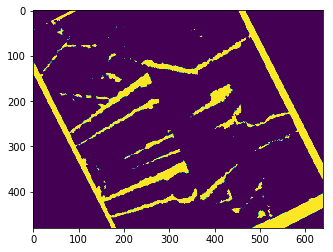

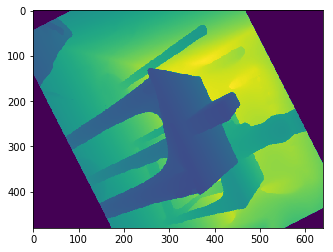

In [71]:
%matplotlib inline
now = train.next()
plt.figure()
plt.imshow(now[1][0][:,:,0])
plt.figure()
plt.imshow(now[0][0][:,:,0])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


<IPython.core.display.Javascript object>


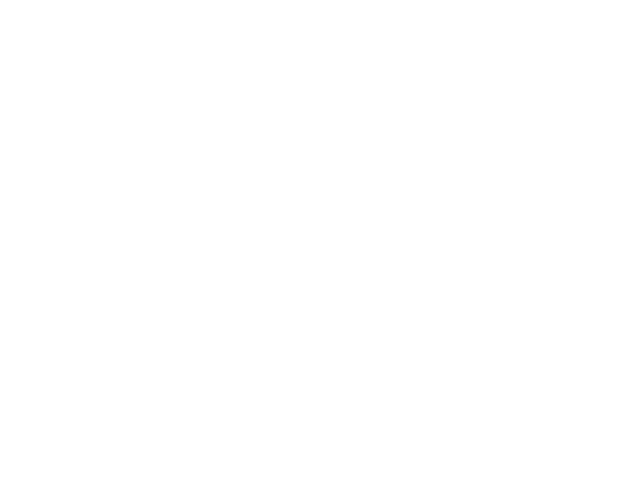

<IPython.core.display.Javascript object>


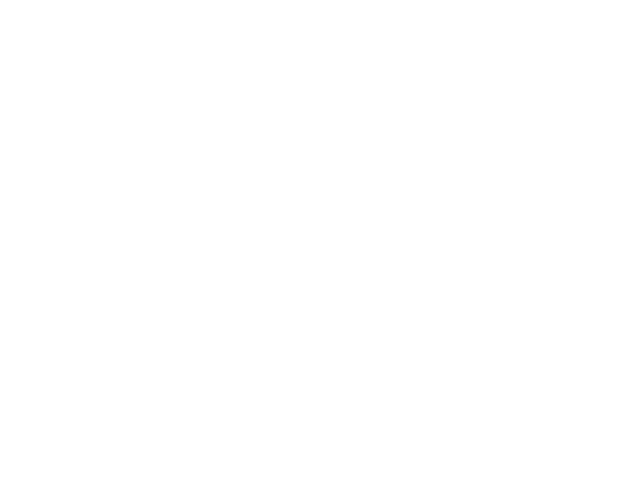

<IPython.core.display.Javascript object>


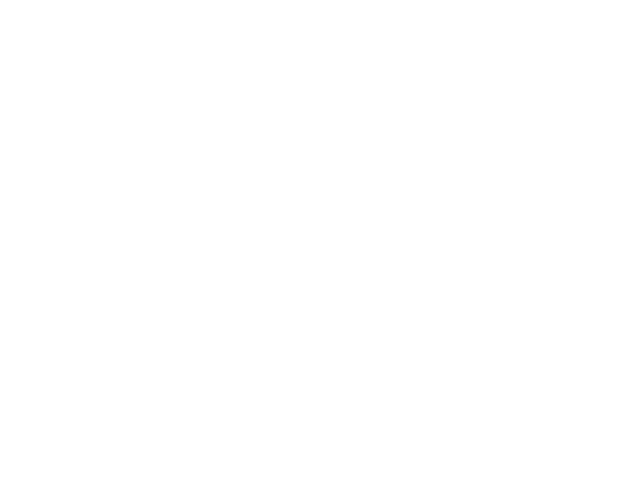

<IPython.core.display.Javascript object>


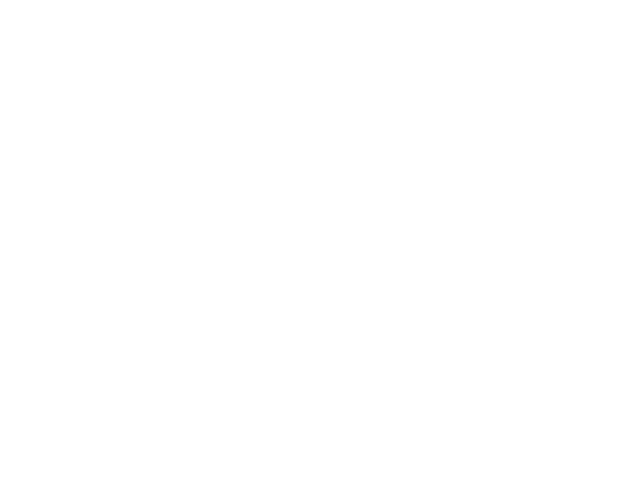

In [58]:
%matplotlib nbagg
now = gen.next()
plt.figure()
plt.imshow(np.reshape(now[1][0],(480,640)))
plt.figure()
plt.imshow(np.reshape(now[0][0,:,:,0],(480,640)))
plt.figure()
plt.imshow(np.reshape(now[0][0,:,:,1:4],(480,640,3)))
plt.figure()
plt.imshow(np.reshape(now[0][0,:,:,4:],(480,640,3)))

In [65]:
img_height = 480 #check with old params
img_width = 640
inputs = Input((img_height, img_width,1))

In [308]:
from keras import models
from keras.layers.core import Activation, Reshape, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
import json

img_w = img_width
img_h = img_height
n_labels = 2

kernel = 3

encoding_layers = [
    Convolution2D(16, kernel, border_mode='same', input_shape=( img_h, img_w,1),data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(16, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(data_format='channels_last'),

    Convolution2D(32, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(32, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(data_format='channels_last'),

    Convolution2D(64, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(64, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(64, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(data_format='channels_last'),

    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(data_format='channels_last'),

    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(128, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(data_format='channels_last'),
]

autoencoder = models.Sequential()
autoencoder.encoding_layers = encoding_layers

for l in autoencoder.encoding_layers:
    autoencoder.add(l)

decoding_layers = [
    UpSampling2D(data_format='channels_last'),
    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(data_format='channels_last'),
    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(64, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(data_format='channels_last'),
    Convolution2D(64, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(64, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(32, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(data_format='channels_last'),
    Convolution2D(32, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(16, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(data_format='channels_last'),
    Convolution2D(16, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(1, 1, border_mode='valid',data_format='channels_last'),
    BatchNormalization(),
]
autoencoder.decoding_layers = decoding_layers
for l in autoencoder.decoding_layers:
    autoencoder.add(l)


#autoencoder.add(Reshape((n_labels, img_h * img_w)))
#autoencoder.add(Permute((2, 1)))
autoencoder.add(Activation('sigmoid'))

autoencoder.summary()
autoencoder.compile(optimizer = optimizers.Adam(lr = 1e-4), loss =  binary_crossentropy, metrics = ['accuracy'])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, 3, padding="same", data_format="channels_last", input_shape=(480, 640,...)`
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, 3, padding="same", data_format="channels_last")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, 3, padding="same", data_format="channels_last")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, 3, padding="same", data_format="channels_last")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, 3, padding="same", data_format="channels_last")`
/usr/local/lib/python2.7/dist-packages/ipyker

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_703 (Conv2D)          (None, 480, 640, 16)      160       
_________________________________________________________________
batch_normalization_703 (Bat (None, 480, 640, 16)      64        
_________________________________________________________________
activation_703 (Activation)  (None, 480, 640, 16)      0         
_________________________________________________________________
conv2d_704 (Conv2D)          (None, 480, 640, 16)      2320      
_________________________________________________________________
batch_normalization_704 (Bat (None, 480, 640, 16)      64        
_________________________________________________________________
activation_704 (Activation)  (None, 480, 640, 16)      0         
_________________________________________________________________
max_pooling2d_136 (MaxPoolin (None, 240, 320, 16)      0         
__________

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()


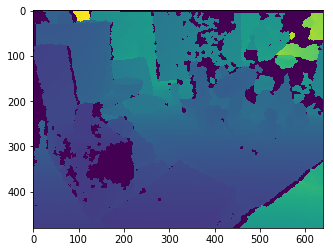

In [337]:
import struct
cpp_int_size = 4
cpp_ushort_size = 2
with open("/media/drc/DATA/linemod/driller/data/depth200.dpt", 'rb') as f:
    rows_b = f.read(cpp_int_size) # I assume that the C++ int in question has 4 bits ... trial and error
    cols_b = f.read(cpp_int_size)

    R = struct.unpack('<i', rows_b)[0] # small endian
    C = struct.unpack('<i', cols_b)[0]
    depth_image_str = f.read(R * C * cpp_ushort_size)
depth_img = np.fromstring(depth_image_str, dtype=np.uint16).reshape([R, C])
plt.imshow(depth_img)

In [338]:
type(depth_img)

numpy.ndarray

In [14]:
%matplotlib nbagg
plt.imshow(misc.imread("/media/drc/DATA/linemod/driller/data/depth572.dpt"))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


IOError: cannot identify image file '/media/drc/DATA/linemod/driller/data/depth572.dpt'

In [ ]:
def convert_to dropout(imgs,autoencoder,out="./"):
    

In [11]:
autoencoder.load_weights("../models/net_segnet_aug.hdf5")

In [1]:
def binary_crossentropy(y_true, y_pred):
    print np.shape(y_true),np.shape(y_pred)
    return K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [ ]:
def weighted_pixelwise_crossentropy(class_weights):
    
    def loss(y_true, y_pred):
        epsilon = tf.convert_to_tensor(.01, y_pred.dtype.base_dtype)
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        return - tf.reduce_sum(tf.multiply(y_true * tf.log(y_pred), tf.convert_to_tensor(class_weights.values())))

    return loss

In [163]:
_EPSILON = 10e-8
from tensorflow.python.ops import clip_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn
def crop1(x,x1 = 100,x2 = 500,y1 = 50, y2 = 450):
    x = x[:,y1:y2,x1:x2,:]
    return x

In [302]:
def binary_crossentropy(target, output, from_logits=False):
    """Binary crossentropy between an output tensor and a target tensor.
      Arguments:
          target: A tensor with the same shape as `output`.
          output: A tensor.
          from_logits: Whether `output` is expected to be a logits tensor.
              By default, we consider that `output`
              encodes a probability distribution.
      Returns:
          A tensor.
      """
    #target  = crop1(target)
   # output = crop1(output)
    #print np.shape(target), np.shape(output)

      # Note: nn.softmax_cross_entropy_with_logits
      # expects logits, Keras expects probabilities.
    if not from_logits:
        # transform back to logits
        epsilon_ =  tf.convert_to_tensor(_EPSILON, output.dtype.base_dtype)
        output = clip_ops.clip_by_value(output, epsilon_, 1 - epsilon_)
        output = math_ops.log(output / (1 - output))
    return nn.weighted_cross_entropy_with_logits(target, output, .15, name=None)


In [72]:
class_weight = {0 : .85,
    1: .15}

In [7]:
batch_size =4

In [327]:
model_checkpoint = ModelCheckpoint('net_segnet_aug_custom metric.hdf5', monitor='loss',verbose=1, save_best_only=True)
check2 = TensorBoard(log_dir='logs1', histogram_freq=0, batch_size=batch_size, write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
print('Fitting model...')
autoencoder.fit_generator(train, nb_epoch=10000,steps_per_epoch=100, verbose=1, shuffle=True, callbacks=[model_checkpoint,check2])

Fitting model...


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., shuffle=True, verbose=1, steps_per_epoch=100, epochs=10000, callbacks=[<keras.ca...)`
  after removing the cwd from sys.path.


Epoch 1/10000


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


 99/100 [============================>.] - ETA: 0s - loss: 0.0305 - acc: 0.9466
Epoch 00001: loss improved from inf to 0.03043, saving model to net_segnet_aug_custom metric.hdf5
100/100 [==============================] - 39s 389ms/step - loss: 0.0304 - acc: 0.9466
Epoch 2/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0317 - acc: 0.9435
Epoch 00002: loss did not improve
100/100 [==============================] - 38s 381ms/step - loss: 0.0317 - acc: 0.9436
Epoch 3/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0318 - acc: 0.9442
Epoch 00003: loss did not improve
100/100 [==============================] - 38s 383ms/step - loss: 0.0317 - acc: 0.9444
Epoch 4/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0324 - acc: 0.9427
Epoch 00004: loss did not improve
100/100 [==============================] - 40s 397ms/step - loss: 0.0323 - acc: 0.9429
Epoch 5/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0325 - acc: 0.9

 99/100 [============================>.] - ETA: 0s - loss: 0.0314 - acc: 0.9446
Epoch 00038: loss did not improve
100/100 [==============================] - 39s 386ms/step - loss: 0.0314 - acc: 0.9446
Epoch 39/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0308 - acc: 0.9444
Epoch 00039: loss did not improve
100/100 [==============================] - 38s 385ms/step - loss: 0.0308 - acc: 0.9444
Epoch 40/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0301 - acc: 0.9455
Epoch 00040: loss improved from 0.03035 to 0.03014, saving model to net_segnet_aug_custom metric.hdf5
100/100 [==============================] - 39s 390ms/step - loss: 0.0301 - acc: 0.9454
Epoch 41/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0300 - acc: 0.9469
Epoch 00041: loss improved from 0.03014 to 0.03002, saving model to net_segnet_aug_custom metric.hdf5
100/100 [==============================] - 39s 390ms/step - loss: 0.0300 - acc: 0.9468
Epoch 42/10000


 99/100 [============================>.] - ETA: 0s - loss: 0.0338 - acc: 0.9392
Epoch 00075: loss did not improve
100/100 [==============================] - 43s 426ms/step - loss: 0.0337 - acc: 0.9393
Epoch 76/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0321 - acc: 0.9427
Epoch 00076: loss did not improve
100/100 [==============================] - 43s 430ms/step - loss: 0.0320 - acc: 0.9429
Epoch 77/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0324 - acc: 0.9425
Epoch 00077: loss did not improve
100/100 [==============================] - 43s 429ms/step - loss: 0.0325 - acc: 0.9424
Epoch 78/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0313 - acc: 0.9439
Epoch 00078: loss did not improve
100/100 [==============================] - 44s 436ms/step - loss: 0.0313 - acc: 0.9439
Epoch 79/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0312 - acc: 0.9446
Epoch 00079: loss did not improve
100/100 [=============

Epoch 113/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0328 - acc: 0.9408
Epoch 00113: loss did not improve
100/100 [==============================] - 46s 457ms/step - loss: 0.0327 - acc: 0.9409
Epoch 114/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0343 - acc: 0.9379
Epoch 00114: loss did not improve
100/100 [==============================] - 44s 441ms/step - loss: 0.0343 - acc: 0.9378
Epoch 115/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0313 - acc: 0.9439
Epoch 00115: loss did not improve
100/100 [==============================] - 45s 447ms/step - loss: 0.0313 - acc: 0.9439
Epoch 116/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0308 - acc: 0.9445
Epoch 00116: loss did not improve
100/100 [==============================] - 45s 450ms/step - loss: 0.0308 - acc: 0.9446
Epoch 117/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0322 - acc: 0.9435
Epoch 00117: loss did not improve
10

Epoch 151/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0317 - acc: 0.9431
Epoch 00151: loss did not improve
100/100 [==============================] - 46s 462ms/step - loss: 0.0318 - acc: 0.9429
Epoch 152/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0308 - acc: 0.9451
Epoch 00152: loss did not improve
100/100 [==============================] - 46s 460ms/step - loss: 0.0308 - acc: 0.9452
Epoch 153/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0320 - acc: 0.9426
Epoch 00153: loss did not improve
100/100 [==============================] - 46s 462ms/step - loss: 0.0321 - acc: 0.9424
Epoch 154/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0322 - acc: 0.9426
Epoch 00154: loss did not improve
100/100 [==============================] - 46s 459ms/step - loss: 0.0322 - acc: 0.9427
Epoch 155/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0316 - acc: 0.9429
Epoch 00155: loss did not improve
10

 99/100 [============================>.] - ETA: 0s - loss: 0.0322 - acc: 0.9424
Epoch 00188: loss did not improve
100/100 [==============================] - 47s 466ms/step - loss: 0.0323 - acc: 0.9424
Epoch 189/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0321 - acc: 0.9421
Epoch 00189: loss did not improve
100/100 [==============================] - 46s 464ms/step - loss: 0.0321 - acc: 0.9421
Epoch 190/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0323 - acc: 0.9425
Epoch 00190: loss did not improve
100/100 [==============================] - 46s 458ms/step - loss: 0.0323 - acc: 0.9425
Epoch 191/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0300 - acc: 0.9470
Epoch 00191: loss did not improve
100/100 [==============================] - 47s 465ms/step - loss: 0.0300 - acc: 0.9472
Epoch 192/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0308 - acc: 0.9451
Epoch 00192: loss did not improve
100/100 [=========

Epoch 226/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0300 - acc: 0.9465
Epoch 00226: loss did not improve
100/100 [==============================] - 46s 458ms/step - loss: 0.0300 - acc: 0.9465
Epoch 227/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0305 - acc: 0.9455
Epoch 00227: loss did not improve
100/100 [==============================] - 46s 465ms/step - loss: 0.0306 - acc: 0.9454
Epoch 228/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0317 - acc: 0.9426
Epoch 00228: loss did not improve
100/100 [==============================] - 47s 468ms/step - loss: 0.0319 - acc: 0.9424
Epoch 229/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0299 - acc: 0.9464
Epoch 00229: loss did not improve
100/100 [==============================] - 46s 461ms/step - loss: 0.0299 - acc: 0.9464
Epoch 230/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0293 - acc: 0.9470
Epoch 00230: loss did not improve
10

Epoch 264/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0307 - acc: 0.9455
Epoch 00264: loss did not improve
100/100 [==============================] - 46s 462ms/step - loss: 0.0306 - acc: 0.9456
Epoch 265/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0303 - acc: 0.9469
Epoch 00265: loss did not improve
100/100 [==============================] - 47s 467ms/step - loss: 0.0302 - acc: 0.9470
Epoch 266/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0306 - acc: 0.9447
Epoch 00266: loss did not improve
100/100 [==============================] - 46s 456ms/step - loss: 0.0305 - acc: 0.9448
Epoch 267/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0311 - acc: 0.9439
Epoch 00267: loss did not improve
100/100 [==============================] - 47s 467ms/step - loss: 0.0310 - acc: 0.9441
Epoch 268/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0316 - acc: 0.9431
Epoch 00268: loss did not improve
10

 99/100 [============================>.] - ETA: 0s - loss: 0.0319 - acc: 0.9430
Epoch 00301: loss did not improve
100/100 [==============================] - 46s 462ms/step - loss: 0.0318 - acc: 0.9432
Epoch 302/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0300 - acc: 0.9457
Epoch 00302: loss did not improve
100/100 [==============================] - 47s 465ms/step - loss: 0.0299 - acc: 0.9459
Epoch 303/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0305 - acc: 0.9453
Epoch 00303: loss did not improve
100/100 [==============================] - 46s 461ms/step - loss: 0.0304 - acc: 0.9454
Epoch 304/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0310 - acc: 0.9444
Epoch 00304: loss did not improve
100/100 [==============================] - 47s 473ms/step - loss: 0.0314 - acc: 0.9436
Epoch 305/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0304 - acc: 0.9451
Epoch 00305: loss did not improve
100/100 [=========

Epoch 339/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0292 - acc: 0.9471
Epoch 00339: loss did not improve
100/100 [==============================] - 47s 474ms/step - loss: 0.0294 - acc: 0.9468
Epoch 340/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0320 - acc: 0.9428
Epoch 00340: loss did not improve
100/100 [==============================] - 47s 473ms/step - loss: 0.0319 - acc: 0.9429
Epoch 341/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0305 - acc: 0.9456
Epoch 00341: loss did not improve
100/100 [==============================] - 46s 458ms/step - loss: 0.0305 - acc: 0.9454
Epoch 342/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0300 - acc: 0.9457
Epoch 00342: loss did not improve
100/100 [==============================] - 46s 462ms/step - loss: 0.0301 - acc: 0.9455
Epoch 343/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0307 - acc: 0.9446
Epoch 00343: loss did not improve
10

Epoch 377/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0290 - acc: 0.9475
Epoch 00377: loss did not improve
100/100 [==============================] - 47s 469ms/step - loss: 0.0290 - acc: 0.9475
Epoch 378/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0316 - acc: 0.9432
Epoch 00378: loss did not improve
100/100 [==============================] - 47s 466ms/step - loss: 0.0317 - acc: 0.9430
Epoch 379/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0291 - acc: 0.9471
Epoch 00379: loss did not improve
100/100 [==============================] - 46s 463ms/step - loss: 0.0291 - acc: 0.9471
Epoch 380/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0325 - acc: 0.9420
Epoch 00380: loss did not improve
100/100 [==============================] - 47s 467ms/step - loss: 0.0327 - acc: 0.9418
Epoch 381/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0314 - acc: 0.9441
Epoch 00381: loss did not improve
10

Epoch 415/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0295 - acc: 0.9466
Epoch 00415: loss did not improve
100/100 [==============================] - 47s 473ms/step - loss: 0.0294 - acc: 0.9468
Epoch 416/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0295 - acc: 0.9472
Epoch 00416: loss did not improve
100/100 [==============================] - 47s 468ms/step - loss: 0.0295 - acc: 0.9471
Epoch 417/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0299 - acc: 0.9462
Epoch 00417: loss did not improve
100/100 [==============================] - 47s 466ms/step - loss: 0.0300 - acc: 0.9460
Epoch 418/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0306 - acc: 0.9447
Epoch 00418: loss did not improve
100/100 [==============================] - 47s 467ms/step - loss: 0.0306 - acc: 0.9448
Epoch 419/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0296 - acc: 0.9462
Epoch 00419: loss did not improve
10

Epoch 453/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0300 - acc: 0.9462
Epoch 00453: loss did not improve
100/100 [==============================] - 48s 478ms/step - loss: 0.0300 - acc: 0.9462
Epoch 454/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0301 - acc: 0.9454
Epoch 00454: loss did not improve
100/100 [==============================] - 47s 468ms/step - loss: 0.0302 - acc: 0.9453
Epoch 455/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0300 - acc: 0.9466
Epoch 00455: loss did not improve
100/100 [==============================] - 47s 467ms/step - loss: 0.0300 - acc: 0.9465
Epoch 456/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0287 - acc: 0.9483
Epoch 00456: loss did not improve
100/100 [==============================] - 47s 466ms/step - loss: 0.0286 - acc: 0.9485
Epoch 457/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0300 - acc: 0.9461
Epoch 00457: loss did not improve
10

 99/100 [============================>.] - ETA: 0s - loss: 0.0293 - acc: 0.9467
Epoch 00490: loss did not improve
100/100 [==============================] - 47s 471ms/step - loss: 0.0293 - acc: 0.9467
Epoch 491/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0298 - acc: 0.9464
Epoch 00491: loss did not improve
100/100 [==============================] - 48s 479ms/step - loss: 0.0299 - acc: 0.9462
Epoch 492/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0302 - acc: 0.9456
Epoch 00492: loss did not improve
100/100 [==============================] - 47s 469ms/step - loss: 0.0302 - acc: 0.9455
Epoch 493/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0313 - acc: 0.9442
Epoch 00493: loss did not improve
100/100 [==============================] - 48s 477ms/step - loss: 0.0313 - acc: 0.9443
Epoch 494/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0312 - acc: 0.9439
Epoch 00494: loss did not improve
100/100 [=========

Epoch 528/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0298 - acc: 0.9471
Epoch 00528: loss did not improve
100/100 [==============================] - 48s 478ms/step - loss: 0.0297 - acc: 0.9473
Epoch 529/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0301 - acc: 0.9460
Epoch 00529: loss did not improve
100/100 [==============================] - 47s 470ms/step - loss: 0.0300 - acc: 0.9460
Epoch 530/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0294 - acc: 0.9470
Epoch 00530: loss did not improve
100/100 [==============================] - 47s 470ms/step - loss: 0.0294 - acc: 0.9470
Epoch 531/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0287 - acc: 0.9482
Epoch 00531: loss did not improve
100/100 [==============================] - 46s 459ms/step - loss: 0.0286 - acc: 0.9484
Epoch 532/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0307 - acc: 0.9444
Epoch 00532: loss did not improve
10

 99/100 [============================>.] - ETA: 0s - loss: 0.0287 - acc: 0.9476
Epoch 00565: loss did not improve
100/100 [==============================] - 48s 479ms/step - loss: 0.0286 - acc: 0.9478
Epoch 566/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0294 - acc: 0.9467
Epoch 00566: loss did not improve
100/100 [==============================] - 48s 483ms/step - loss: 0.0295 - acc: 0.9466
Epoch 567/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0298 - acc: 0.9459
Epoch 00567: loss did not improve
100/100 [==============================] - 48s 479ms/step - loss: 0.0298 - acc: 0.9458
Epoch 568/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0299 - acc: 0.9461
Epoch 00568: loss did not improve
100/100 [==============================] - 48s 479ms/step - loss: 0.0300 - acc: 0.9460
Epoch 569/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0296 - acc: 0.9474
Epoch 00569: loss did not improve
100/100 [=========

Epoch 603/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0283 - acc: 0.9486
Epoch 00603: loss did not improve
100/100 [==============================] - 38s 383ms/step - loss: 0.0283 - acc: 0.9486
Epoch 604/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0301 - acc: 0.9456
Epoch 00604: loss did not improve
100/100 [==============================] - 38s 382ms/step - loss: 0.0301 - acc: 0.9454
Epoch 605/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0305 - acc: 0.9444
Epoch 00605: loss did not improve
100/100 [==============================] - 38s 383ms/step - loss: 0.0305 - acc: 0.9444
Epoch 606/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0310 - acc: 0.9445
Epoch 00606: loss did not improve
100/100 [==============================] - 38s 382ms/step - loss: 0.0309 - acc: 0.9446
Epoch 607/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0288 - acc: 0.9480
Epoch 00607: loss did not improve
10

 99/100 [============================>.] - ETA: 0s - loss: 0.0284 - acc: 0.9494
Epoch 00640: loss did not improve
100/100 [==============================] - 43s 429ms/step - loss: 0.0284 - acc: 0.9495
Epoch 641/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0284 - acc: 0.9482
Epoch 00641: loss did not improve
100/100 [==============================] - 44s 439ms/step - loss: 0.0284 - acc: 0.9482
Epoch 642/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0277 - acc: 0.9495
Epoch 00642: loss did not improve
100/100 [==============================] - 43s 425ms/step - loss: 0.0280 - acc: 0.9491
Epoch 643/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0290 - acc: 0.9477
Epoch 00643: loss did not improve
100/100 [==============================] - 44s 440ms/step - loss: 0.0290 - acc: 0.9476
Epoch 644/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0299 - acc: 0.9447
Epoch 00644: loss did not improve
100/100 [=========

Epoch 678/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0292 - acc: 0.9477
Epoch 00678: loss did not improve
100/100 [==============================] - 46s 464ms/step - loss: 0.0292 - acc: 0.9477
Epoch 679/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0300 - acc: 0.9454
Epoch 00679: loss did not improve
100/100 [==============================] - 46s 462ms/step - loss: 0.0299 - acc: 0.9454
Epoch 680/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0279 - acc: 0.9492
Epoch 00680: loss did not improve
100/100 [==============================] - 46s 458ms/step - loss: 0.0279 - acc: 0.9491
Epoch 681/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0298 - acc: 0.9462
Epoch 00681: loss did not improve
100/100 [==============================] - 45s 446ms/step - loss: 0.0297 - acc: 0.9463
Epoch 682/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0293 - acc: 0.9464
Epoch 00682: loss did not improve
10

 99/100 [============================>.] - ETA: 0s - loss: 0.0294 - acc: 0.9465
Epoch 00715: loss did not improve
100/100 [==============================] - 44s 443ms/step - loss: 0.0296 - acc: 0.9462
Epoch 716/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0285 - acc: 0.9487
Epoch 00716: loss did not improve
100/100 [==============================] - 45s 450ms/step - loss: 0.0284 - acc: 0.9487
Epoch 717/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0286 - acc: 0.9482
Epoch 00717: loss did not improve
100/100 [==============================] - 46s 460ms/step - loss: 0.0286 - acc: 0.9483
Epoch 718/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0292 - acc: 0.9470
Epoch 00718: loss did not improve
100/100 [==============================] - 47s 472ms/step - loss: 0.0292 - acc: 0.9469
Epoch 719/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0310 - acc: 0.9432
Epoch 00719: loss did not improve
100/100 [=========

Epoch 753/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0293 - acc: 0.9475
Epoch 00753: loss did not improve
100/100 [==============================] - 45s 455ms/step - loss: 0.0294 - acc: 0.9474
Epoch 754/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0280 - acc: 0.9498
Epoch 00754: loss did not improve
100/100 [==============================] - 47s 471ms/step - loss: 0.0280 - acc: 0.9498
Epoch 755/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0293 - acc: 0.9469
Epoch 00755: loss did not improve
100/100 [==============================] - 47s 473ms/step - loss: 0.0293 - acc: 0.9469
Epoch 756/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0293 - acc: 0.9467
Epoch 00756: loss did not improve
100/100 [==============================] - 46s 460ms/step - loss: 0.0292 - acc: 0.9468
Epoch 757/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0302 - acc: 0.9453
Epoch 00757: loss did not improve
10

Epoch 791/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0290 - acc: 0.9474
Epoch 00791: loss did not improve
100/100 [==============================] - 46s 463ms/step - loss: 0.0290 - acc: 0.9474
Epoch 792/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0295 - acc: 0.9462
Epoch 00792: loss did not improve
100/100 [==============================] - 47s 474ms/step - loss: 0.0294 - acc: 0.9463
Epoch 793/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0307 - acc: 0.9447
Epoch 00793: loss did not improve
100/100 [==============================] - 46s 461ms/step - loss: 0.0307 - acc: 0.9446
Epoch 794/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0309 - acc: 0.9442
Epoch 00794: loss did not improve
100/100 [==============================] - 46s 460ms/step - loss: 0.0312 - acc: 0.9440
Epoch 795/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0280 - acc: 0.9495
Epoch 00795: loss did not improve
10

Epoch 829/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0285 - acc: 0.9479
Epoch 00829: loss did not improve
100/100 [==============================] - 47s 472ms/step - loss: 0.0285 - acc: 0.9478
Epoch 830/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0277 - acc: 0.9504
Epoch 00830: loss did not improve
100/100 [==============================] - 46s 461ms/step - loss: 0.0277 - acc: 0.9502
Epoch 831/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0323 - acc: 0.9423
Epoch 00831: loss did not improve
100/100 [==============================] - 47s 468ms/step - loss: 0.0323 - acc: 0.9423
Epoch 832/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0306 - acc: 0.9453
Epoch 00832: loss did not improve
100/100 [==============================] - 48s 480ms/step - loss: 0.0305 - acc: 0.9455
Epoch 833/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0282 - acc: 0.9493
Epoch 00833: loss did not improve
10

 99/100 [============================>.] - ETA: 0s - loss: 0.0298 - acc: 0.9463
Epoch 00866: loss did not improve
100/100 [==============================] - 46s 463ms/step - loss: 0.0297 - acc: 0.9464
Epoch 867/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0297 - acc: 0.9456
Epoch 00867: loss did not improve
100/100 [==============================] - 48s 477ms/step - loss: 0.0297 - acc: 0.9456
Epoch 868/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0285 - acc: 0.9479
Epoch 00868: loss did not improve
100/100 [==============================] - 47s 474ms/step - loss: 0.0286 - acc: 0.9478
Epoch 869/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0292 - acc: 0.9470
Epoch 00869: loss did not improve
100/100 [==============================] - 47s 470ms/step - loss: 0.0292 - acc: 0.9469
Epoch 870/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0285 - acc: 0.9477
Epoch 00870: loss did not improve
100/100 [=========

Epoch 904/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0301 - acc: 0.9456
Epoch 00904: loss did not improve
100/100 [==============================] - 48s 480ms/step - loss: 0.0301 - acc: 0.9456
Epoch 905/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0277 - acc: 0.9495
Epoch 00905: loss did not improve
100/100 [==============================] - 47s 468ms/step - loss: 0.0276 - acc: 0.9495
Epoch 906/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0297 - acc: 0.9463
Epoch 00906: loss did not improve
100/100 [==============================] - 48s 480ms/step - loss: 0.0297 - acc: 0.9462
Epoch 907/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0285 - acc: 0.9479
Epoch 00907: loss did not improve
100/100 [==============================] - 47s 474ms/step - loss: 0.0285 - acc: 0.9478
Epoch 908/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0270 - acc: 0.9508
Epoch 00908: loss did not improve
10

Epoch 942/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0283 - acc: 0.9484
Epoch 00942: loss did not improve
100/100 [==============================] - 47s 472ms/step - loss: 0.0282 - acc: 0.9485
Epoch 943/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0295 - acc: 0.9463
Epoch 00943: loss did not improve
100/100 [==============================] - 48s 477ms/step - loss: 0.0294 - acc: 0.9465
Epoch 944/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0284 - acc: 0.9483
Epoch 00944: loss did not improve
100/100 [==============================] - 47s 473ms/step - loss: 0.0285 - acc: 0.9481
Epoch 945/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0275 - acc: 0.9502
Epoch 00945: loss did not improve
100/100 [==============================] - 46s 463ms/step - loss: 0.0274 - acc: 0.9502
Epoch 946/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0270 - acc: 0.9508
Epoch 00946: loss did not improve
10

 99/100 [============================>.] - ETA: 0s - loss: 0.0286 - acc: 0.9480
Epoch 00979: loss did not improve
100/100 [==============================] - 47s 472ms/step - loss: 0.0285 - acc: 0.9481
Epoch 980/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0295 - acc: 0.9460
Epoch 00980: loss did not improve
100/100 [==============================] - 47s 467ms/step - loss: 0.0295 - acc: 0.9461
Epoch 981/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0289 - acc: 0.9475
Epoch 00981: loss did not improve
100/100 [==============================] - 48s 484ms/step - loss: 0.0288 - acc: 0.9476
Epoch 982/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0272 - acc: 0.9499
Epoch 00982: loss did not improve
100/100 [==============================] - 48s 480ms/step - loss: 0.0274 - acc: 0.9496
Epoch 983/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0278 - acc: 0.9497
Epoch 00983: loss did not improve
100/100 [=========

Epoch 1017/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0281 - acc: 0.9489
Epoch 01017: loss did not improve
100/100 [==============================] - 47s 474ms/step - loss: 0.0282 - acc: 0.9488
Epoch 1018/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0297 - acc: 0.9467
Epoch 01018: loss did not improve
100/100 [==============================] - 48s 478ms/step - loss: 0.0297 - acc: 0.9466
Epoch 1019/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0280 - acc: 0.9484
Epoch 01019: loss did not improve
100/100 [==============================] - 48s 484ms/step - loss: 0.0279 - acc: 0.9485
Epoch 1020/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0292 - acc: 0.9480
Epoch 01020: loss did not improve
100/100 [==============================] - 48s 478ms/step - loss: 0.0291 - acc: 0.9481
Epoch 1021/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0270 - acc: 0.9510
Epoch 01021: loss did not impro

Epoch 1055/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0280 - acc: 0.9492
Epoch 01055: loss did not improve
100/100 [==============================] - 48s 476ms/step - loss: 0.0281 - acc: 0.9491
Epoch 1056/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0291 - acc: 0.9477
Epoch 01056: loss did not improve
100/100 [==============================] - 47s 467ms/step - loss: 0.0292 - acc: 0.9476
Epoch 1057/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0283 - acc: 0.9481
Epoch 01057: loss did not improve
100/100 [==============================] - 47s 470ms/step - loss: 0.0284 - acc: 0.9479
Epoch 1058/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0297 - acc: 0.9462
Epoch 01058: loss did not improve
100/100 [==============================] - 48s 475ms/step - loss: 0.0297 - acc: 0.9462
Epoch 1059/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0281 - acc: 0.9484
Epoch 01059: loss did not impro

Epoch 1093/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0289 - acc: 0.9475
Epoch 01093: loss did not improve
100/100 [==============================] - 47s 475ms/step - loss: 0.0290 - acc: 0.9474
Epoch 1094/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0282 - acc: 0.9492
Epoch 01094: loss did not improve
100/100 [==============================] - 47s 474ms/step - loss: 0.0283 - acc: 0.9491
Epoch 1095/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0287 - acc: 0.9482
Epoch 01095: loss did not improve
100/100 [==============================] - 47s 473ms/step - loss: 0.0286 - acc: 0.9484
Epoch 1096/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0271 - acc: 0.9511
Epoch 01096: loss did not improve
100/100 [==============================] - 47s 474ms/step - loss: 0.0272 - acc: 0.9512
Epoch 1097/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0292 - acc: 0.9477
Epoch 01097: loss did not impro

Epoch 1131/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0288 - acc: 0.9468
Epoch 01131: loss did not improve
100/100 [==============================] - 48s 479ms/step - loss: 0.0288 - acc: 0.9468
Epoch 1132/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0285 - acc: 0.9485
Epoch 01132: loss did not improve
100/100 [==============================] - 48s 484ms/step - loss: 0.0284 - acc: 0.9486
Epoch 1133/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0286 - acc: 0.9471
Epoch 01133: loss did not improve
100/100 [==============================] - 48s 479ms/step - loss: 0.0286 - acc: 0.9473
Epoch 1134/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0268 - acc: 0.9511
Epoch 01134: loss did not improve
100/100 [==============================] - 48s 476ms/step - loss: 0.0267 - acc: 0.9512
Epoch 1135/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0278 - acc: 0.9497
Epoch 01135: loss did not impro

 99/100 [============================>.] - ETA: 0s - loss: 0.0264 - acc: 0.9520
Epoch 01168: loss did not improve
100/100 [==============================] - 38s 383ms/step - loss: 0.0265 - acc: 0.9520
Epoch 1169/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0292 - acc: 0.9465
Epoch 01169: loss did not improve
100/100 [==============================] - 38s 383ms/step - loss: 0.0292 - acc: 0.9465
Epoch 1170/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0301 - acc: 0.9448
Epoch 01170: loss did not improve
100/100 [==============================] - 38s 383ms/step - loss: 0.0302 - acc: 0.9446
Epoch 1171/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0287 - acc: 0.9481
Epoch 01171: loss did not improve
100/100 [==============================] - 38s 383ms/step - loss: 0.0286 - acc: 0.9482
Epoch 1172/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0275 - acc: 0.9498
Epoch 01172: loss did not improve
100/100 [=====

 99/100 [============================>.] - ETA: 0s - loss: 0.0288 - acc: 0.9477
Epoch 01205: loss did not improve
100/100 [==============================] - 45s 447ms/step - loss: 0.0291 - acc: 0.9469
Epoch 1206/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0276 - acc: 0.9495
Epoch 01206: loss did not improve
100/100 [==============================] - 43s 434ms/step - loss: 0.0276 - acc: 0.9495
Epoch 1207/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0284 - acc: 0.9481
Epoch 01207: loss did not improve
100/100 [==============================] - 44s 442ms/step - loss: 0.0283 - acc: 0.9481
Epoch 1208/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0269 - acc: 0.9504
Epoch 01208: loss did not improve
100/100 [==============================] - 44s 436ms/step - loss: 0.0269 - acc: 0.9505
Epoch 1209/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0284 - acc: 0.9486
Epoch 01209: loss did not improve
100/100 [=====

Epoch 1243/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0286 - acc: 0.9475
Epoch 01243: loss did not improve
100/100 [==============================] - 46s 462ms/step - loss: 0.0285 - acc: 0.9476
Epoch 1244/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0307 - acc: 0.9439
Epoch 01244: loss did not improve
100/100 [==============================] - 45s 451ms/step - loss: 0.0306 - acc: 0.9441
Epoch 1245/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0286 - acc: 0.9478
Epoch 01245: loss did not improve
100/100 [==============================] - 45s 446ms/step - loss: 0.0286 - acc: 0.9477
Epoch 1246/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0281 - acc: 0.9481
Epoch 01246: loss did not improve
100/100 [==============================] - 46s 456ms/step - loss: 0.0282 - acc: 0.9480
Epoch 1247/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0284 - acc: 0.9484
Epoch 01247: loss did not impro

 99/100 [============================>.] - ETA: 0s - loss: 0.0289 - acc: 0.9474
Epoch 01280: loss did not improve
100/100 [==============================] - 46s 456ms/step - loss: 0.0289 - acc: 0.9474
Epoch 1281/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0281 - acc: 0.9496
Epoch 01281: loss did not improve
100/100 [==============================] - 47s 474ms/step - loss: 0.0281 - acc: 0.9496
Epoch 1282/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0265 - acc: 0.9513
Epoch 01282: loss did not improve
100/100 [==============================] - 47s 472ms/step - loss: 0.0265 - acc: 0.9515
Epoch 1283/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0287 - acc: 0.9479
Epoch 01283: loss did not improve
100/100 [==============================] - 47s 471ms/step - loss: 0.0288 - acc: 0.9477
Epoch 1284/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0273 - acc: 0.9490
Epoch 01284: loss did not improve
100/100 [=====

Epoch 1318/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0289 - acc: 0.9469
Epoch 01318: loss did not improve
100/100 [==============================] - 47s 468ms/step - loss: 0.0289 - acc: 0.9466
Epoch 1319/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0277 - acc: 0.9494
Epoch 01319: loss did not improve
100/100 [==============================] - 46s 460ms/step - loss: 0.0278 - acc: 0.9492
Epoch 1320/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0276 - acc: 0.9487
Epoch 01320: loss did not improve
100/100 [==============================] - 46s 464ms/step - loss: 0.0276 - acc: 0.9488
Epoch 1321/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0279 - acc: 0.9489
Epoch 01321: loss did not improve
100/100 [==============================] - 46s 462ms/step - loss: 0.0279 - acc: 0.9489
Epoch 1322/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0288 - acc: 0.9476
Epoch 01322: loss did not impro

Epoch 1356/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0278 - acc: 0.9496
Epoch 01356: loss did not improve
100/100 [==============================] - 49s 488ms/step - loss: 0.0277 - acc: 0.9498
Epoch 1357/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0264 - acc: 0.9516
Epoch 01357: loss did not improve
100/100 [==============================] - 48s 482ms/step - loss: 0.0265 - acc: 0.9515
Epoch 1358/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0277 - acc: 0.9487
Epoch 01358: loss did not improve
100/100 [==============================] - 48s 476ms/step - loss: 0.0277 - acc: 0.9487
Epoch 1359/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0264 - acc: 0.9509
Epoch 01359: loss did not improve
100/100 [==============================] - 48s 481ms/step - loss: 0.0265 - acc: 0.9507
Epoch 1360/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0280 - acc: 0.9486
Epoch 01360: loss did not impro

Epoch 1394/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0280 - acc: 0.9488
Epoch 01394: loss did not improve
100/100 [==============================] - 47s 474ms/step - loss: 0.0282 - acc: 0.9485
Epoch 1395/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0279 - acc: 0.9495
Epoch 01395: loss did not improve
100/100 [==============================] - 46s 460ms/step - loss: 0.0278 - acc: 0.9496
Epoch 1396/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0264 - acc: 0.9520
Epoch 01396: loss did not improve
100/100 [==============================] - 47s 473ms/step - loss: 0.0264 - acc: 0.9520
Epoch 1397/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0282 - acc: 0.9492
Epoch 01397: loss did not improve
100/100 [==============================] - 46s 460ms/step - loss: 0.0283 - acc: 0.9491
Epoch 1398/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0275 - acc: 0.9495
Epoch 01398: loss did not impro

Epoch 1432/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0276 - acc: 0.9496
Epoch 01432: loss did not improve
100/100 [==============================] - 48s 478ms/step - loss: 0.0275 - acc: 0.9497
Epoch 1433/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0295 - acc: 0.9457
Epoch 01433: loss did not improve
100/100 [==============================] - 48s 478ms/step - loss: 0.0295 - acc: 0.9458
Epoch 1434/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0290 - acc: 0.9470
Epoch 01434: loss did not improve
100/100 [==============================] - 47s 473ms/step - loss: 0.0290 - acc: 0.9470
Epoch 1435/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0268 - acc: 0.9511
Epoch 01435: loss did not improve
100/100 [==============================] - 45s 455ms/step - loss: 0.0268 - acc: 0.9512
Epoch 1436/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0293 - acc: 0.9468
Epoch 01436: loss did not impro

 99/100 [============================>.] - ETA: 0s - loss: 0.0280 - acc: 0.9488
Epoch 01469: loss did not improve
100/100 [==============================] - 47s 467ms/step - loss: 0.0280 - acc: 0.9488
Epoch 1470/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0277 - acc: 0.9489
Epoch 01470: loss did not improve
100/100 [==============================] - 47s 474ms/step - loss: 0.0278 - acc: 0.9488
Epoch 1471/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0290 - acc: 0.9473
Epoch 01471: loss did not improve
100/100 [==============================] - 47s 469ms/step - loss: 0.0290 - acc: 0.9474
Epoch 1472/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0277 - acc: 0.9494
Epoch 01472: loss did not improve
100/100 [==============================] - 47s 465ms/step - loss: 0.0276 - acc: 0.9495
Epoch 1473/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0291 - acc: 0.9478
Epoch 01473: loss did not improve
100/100 [=====

Epoch 1507/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0265 - acc: 0.9507
Epoch 01507: loss did not improve
100/100 [==============================] - 47s 473ms/step - loss: 0.0265 - acc: 0.9508
Epoch 1508/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0277 - acc: 0.9499
Epoch 01508: loss did not improve
100/100 [==============================] - 48s 482ms/step - loss: 0.0277 - acc: 0.9501
Epoch 1509/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0278 - acc: 0.9493
Epoch 01509: loss did not improve
100/100 [==============================] - 49s 490ms/step - loss: 0.0279 - acc: 0.9493
Epoch 1510/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0272 - acc: 0.9502
Epoch 01510: loss did not improve
100/100 [==============================] - 47s 475ms/step - loss: 0.0273 - acc: 0.9502
Epoch 1511/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0269 - acc: 0.9505
Epoch 01511: loss did not impro

 99/100 [============================>.] - ETA: 0s - loss: 0.0266 - acc: 0.9514
Epoch 01544: loss did not improve
100/100 [==============================] - 47s 474ms/step - loss: 0.0266 - acc: 0.9513
Epoch 1545/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0275 - acc: 0.9495
Epoch 01545: loss did not improve
100/100 [==============================] - 47s 470ms/step - loss: 0.0275 - acc: 0.9496
Epoch 1546/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0265 - acc: 0.9511
Epoch 01546: loss did not improve
100/100 [==============================] - 48s 480ms/step - loss: 0.0264 - acc: 0.9512
Epoch 1547/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0279 - acc: 0.9499
Epoch 01547: loss did not improve
100/100 [==============================] - 48s 479ms/step - loss: 0.0282 - acc: 0.9492
Epoch 1548/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0287 - acc: 0.9481
Epoch 01548: loss did not improve
100/100 [=====

Epoch 1582/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0265 - acc: 0.9511
Epoch 01582: loss did not improve
100/100 [==============================] - 48s 485ms/step - loss: 0.0266 - acc: 0.9511
Epoch 1583/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0283 - acc: 0.9482
Epoch 01583: loss did not improve
100/100 [==============================] - 48s 478ms/step - loss: 0.0282 - acc: 0.9482
Epoch 1584/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0271 - acc: 0.9506
Epoch 01584: loss did not improve
100/100 [==============================] - 48s 483ms/step - loss: 0.0271 - acc: 0.9506
Epoch 1585/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0278 - acc: 0.9494
Epoch 01585: loss did not improve
100/100 [==============================] - 47s 467ms/step - loss: 0.0279 - acc: 0.9493
Epoch 1586/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0264 - acc: 0.9514
Epoch 01586: loss did not impro

Epoch 1620/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0276 - acc: 0.9500
Epoch 01620: loss did not improve
100/100 [==============================] - 47s 475ms/step - loss: 0.0277 - acc: 0.9498
Epoch 1621/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0270 - acc: 0.9501
Epoch 01621: loss did not improve
100/100 [==============================] - 47s 474ms/step - loss: 0.0270 - acc: 0.9503
Epoch 1622/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0292 - acc: 0.9468
Epoch 01622: loss did not improve
100/100 [==============================] - 48s 484ms/step - loss: 0.0291 - acc: 0.9468
Epoch 1623/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0281 - acc: 0.9489
Epoch 01623: loss did not improve
100/100 [==============================] - 48s 475ms/step - loss: 0.0281 - acc: 0.9488
Epoch 1624/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0275 - acc: 0.9489
Epoch 01624: loss did not impro

Epoch 1658/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0275 - acc: 0.9499
Epoch 01658: loss did not improve
100/100 [==============================] - 49s 486ms/step - loss: 0.0275 - acc: 0.9499
Epoch 1659/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0277 - acc: 0.9492
Epoch 01659: loss did not improve
100/100 [==============================] - 48s 478ms/step - loss: 0.0276 - acc: 0.9493
Epoch 1660/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0268 - acc: 0.9510
Epoch 01660: loss did not improve
100/100 [==============================] - 49s 494ms/step - loss: 0.0269 - acc: 0.9508
Epoch 1661/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0272 - acc: 0.9499
Epoch 01661: loss did not improve
100/100 [==============================] - 49s 488ms/step - loss: 0.0272 - acc: 0.9498
Epoch 1662/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0294 - acc: 0.9460
Epoch 01662: loss did not impro

 99/100 [============================>.] - ETA: 0s - loss: 0.0273 - acc: 0.9497
Epoch 01695: loss did not improve
100/100 [==============================] - 48s 477ms/step - loss: 0.0273 - acc: 0.9496
Epoch 1696/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0277 - acc: 0.9497
Epoch 01696: loss did not improve
100/100 [==============================] - 48s 478ms/step - loss: 0.0277 - acc: 0.9497
Epoch 1697/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0272 - acc: 0.9499
Epoch 01697: loss did not improve
100/100 [==============================] - 48s 480ms/step - loss: 0.0271 - acc: 0.9500
Epoch 1698/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0269 - acc: 0.9506
Epoch 01698: loss did not improve
100/100 [==============================] - 48s 483ms/step - loss: 0.0270 - acc: 0.9503
Epoch 1699/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0275 - acc: 0.9498
Epoch 01699: loss did not improve
100/100 [=====

Epoch 1733/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0282 - acc: 0.9478
Epoch 01733: loss did not improve
100/100 [==============================] - 38s 383ms/step - loss: 0.0282 - acc: 0.9478
Epoch 1734/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0271 - acc: 0.9504
Epoch 01734: loss did not improve
100/100 [==============================] - 38s 383ms/step - loss: 0.0270 - acc: 0.9506
Epoch 1735/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0269 - acc: 0.9510
Epoch 01735: loss did not improve
100/100 [==============================] - 38s 383ms/step - loss: 0.0269 - acc: 0.9511
Epoch 1736/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0288 - acc: 0.9475
Epoch 01736: loss did not improve
100/100 [==============================] - 38s 383ms/step - loss: 0.0288 - acc: 0.9475
Epoch 1737/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0261 - acc: 0.9522
Epoch 01737: loss did not impro

Epoch 1771/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0282 - acc: 0.9478
Epoch 01771: loss did not improve
100/100 [==============================] - 43s 431ms/step - loss: 0.0281 - acc: 0.9480
Epoch 1772/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0263 - acc: 0.9524
Epoch 01772: loss did not improve
100/100 [==============================] - 44s 443ms/step - loss: 0.0264 - acc: 0.9523
Epoch 1773/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0266 - acc: 0.9512
Epoch 01773: loss did not improve
100/100 [==============================] - 44s 438ms/step - loss: 0.0265 - acc: 0.9513
Epoch 1774/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0270 - acc: 0.9499
Epoch 01774: loss did not improve
100/100 [==============================] - 45s 446ms/step - loss: 0.0269 - acc: 0.9500
Epoch 1775/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0269 - acc: 0.9496
Epoch 01775: loss did not impro

Epoch 1809/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9513
Epoch 01809: loss did not improve
100/100 [==============================] - 47s 468ms/step - loss: 0.0267 - acc: 0.9513
Epoch 1810/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0277 - acc: 0.9496
Epoch 01810: loss did not improve
100/100 [==============================] - 46s 464ms/step - loss: 0.0278 - acc: 0.9496
Epoch 1811/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9504
Epoch 01811: loss did not improve
100/100 [==============================] - 46s 456ms/step - loss: 0.0271 - acc: 0.9500
Epoch 1812/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0279 - acc: 0.9485
Epoch 01812: loss did not improve
100/100 [==============================] - 46s 455ms/step - loss: 0.0280 - acc: 0.9484
Epoch 1813/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0284 - acc: 0.9484
Epoch 01813: loss did not impro

Epoch 1847/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0248 - acc: 0.9543
Epoch 01847: loss improved from 0.02548 to 0.02474, saving model to net_segnet_aug_custom metric.hdf5
100/100 [==============================] - 46s 459ms/step - loss: 0.0247 - acc: 0.9545
Epoch 1848/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0265 - acc: 0.9518
Epoch 01848: loss did not improve
100/100 [==============================] - 46s 463ms/step - loss: 0.0264 - acc: 0.9519
Epoch 1849/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0294 - acc: 0.9463
Epoch 01849: loss did not improve
100/100 [==============================] - 47s 475ms/step - loss: 0.0293 - acc: 0.9465
Epoch 1850/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0265 - acc: 0.9515
Epoch 01850: loss did not improve
100/100 [==============================] - 46s 464ms/step - loss: 0.0266 - acc: 0.9514
Epoch 1851/10000
 99/100 [============================>.] - 

 99/100 [============================>.] - ETA: 0s - loss: 0.0272 - acc: 0.9503
Epoch 01884: loss did not improve
100/100 [==============================] - 47s 465ms/step - loss: 0.0271 - acc: 0.9502
Epoch 1885/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0283 - acc: 0.9484
Epoch 01885: loss did not improve
100/100 [==============================] - 47s 471ms/step - loss: 0.0283 - acc: 0.9484
Epoch 1886/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0269 - acc: 0.9507
Epoch 01886: loss did not improve
100/100 [==============================] - 47s 466ms/step - loss: 0.0268 - acc: 0.9508
Epoch 1887/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0277 - acc: 0.9489
Epoch 01887: loss did not improve
100/100 [==============================] - 47s 465ms/step - loss: 0.0277 - acc: 0.9490
Epoch 1888/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0278 - acc: 0.9485
Epoch 01888: loss did not improve
100/100 [=====

Epoch 1922/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0281 - acc: 0.9483
Epoch 01922: loss did not improve
100/100 [==============================] - 47s 473ms/step - loss: 0.0282 - acc: 0.9481
Epoch 1923/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0268 - acc: 0.9508
Epoch 01923: loss did not improve
100/100 [==============================] - 47s 473ms/step - loss: 0.0267 - acc: 0.9509
Epoch 1924/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0294 - acc: 0.9465
Epoch 01924: loss did not improve
100/100 [==============================] - 47s 474ms/step - loss: 0.0293 - acc: 0.9465
Epoch 1925/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0271 - acc: 0.9506
Epoch 01925: loss did not improve
100/100 [==============================] - 48s 475ms/step - loss: 0.0271 - acc: 0.9506
Epoch 1926/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0255 - acc: 0.9533
Epoch 01926: loss did not impro

KeyboardInterrupt: 

In [ ]:
# conv1 = Conv2D(4, 3, activation = 'relu', padding = 'same',data_format='channels_last')(inputs)
conv1 = Conv2D(4, 3, activation = 'relu', padding = 'same',data_format='channels_last')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv1)

conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same',data_format='channels_last')(pool1)
conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same',data_format='channels_last')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv2)

up8 = Conv2D(8, 2, activation = 'relu', padding = 'same',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(pool2))
conv8 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(up8)

up9 = Conv2D(4, 2, activation = 'relu', padding = 'same', data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv8))
conv9 = Conv2D(4, 3, activation = 'relu', padding = 'same',data_format='channels_last')(up9)
conv10 = Conv2D(1, 1, activation = 'sigmoid',data_format='channels_last')(conv9)
#crop = Cropping2D(cropping=((0, 0), (0, 0)), data_format='channels_last')


model = Model(input = inputs, output = conv10)
print model.summary()
model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [336]:
conv1 = LocallyConnected2D(4, 3, activation = 'relu', padding = 'valid',data_format='channels_last')(inputs)
conv1 = LocallyConnected2D(4, 3, activation = 'relu', padding = 'valid',data_format='channels_last')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv1)

conv2 = LocallyConnected2D(16, 3, activation = 'relu', padding = 'valid',data_format='channels_last')(pool1)
conv2 = LocallyConnected2D(16, 3, activation = 'relu', padding = 'valid',data_format='channels_last')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv2)

up8 = LocallyConnected2D(8, 2, activation = 'relu', padding = 'valid',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(pool2))
conv8 = LocallyConnected2D(8, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal',data_format='channels_last')(conv8)

up9 = LocallyConnected2D(4, 2, activation = 'relu', padding = 'valid', data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv8))
conv9 = LocallyConnected2D(4, 3, activation = 'relu', padding = 'valid',data_format='channels_last')(conv9)
conv10 = LocallyConnected2D(1, 1, activation = 'sigmoid',data_format='channels_last')(conv9)
#crop = Cropping2D(cropping=((0, 0), (0, 0)), data_format='channels_last')


model = Model(input = inputs, output = conv10)
print model.summary()
model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

KeyboardInterrupt: 

In [250]:
conv1 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(inputs)
conv1 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv1)

conv2 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool1)
conv2 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv2)

conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool2)
conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv3)


conv5 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool3)
conv5 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv5)
drop5 = Dropout(0.5)(conv5)

up7 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv5))
merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge7)
conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv7)

up8 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv7))
merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
conv8 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge8)
conv8 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv8)

up9 = Conv2D(4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv8))
merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
conv9 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge9)
conv9 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid',data_format='channels_last')(conv9)
#crop = Cropping2D(cropping=((0, 0), (0, 0)), data_format='channels_last')


model = Model(input = inputs, output = conv10)
print model.summary()
model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 400, 400, 1)  0                                            
__________________________________________________________________________________________________
conv2d_168 (Conv2D)             (None, 400, 400, 4)  40          input_14[0][0]                   
__________________________________________________________________________________________________
conv2d_169 (Conv2D)             (None, 400, 400, 4)  148         conv2d_168[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_40 (MaxPooling2D) (None, 200, 200, 4)  0           conv2d_169[0][0]                 
__________________________________________________________________________________________________
conv2d_170

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:29: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


In [113]:
def network(input_image_tensor):
    def resnet_block_1(input_features, nb_features=16, nb_kernel_rows=3, nb_kernel_cols=3):

        y = Conv2D(nb_features, nb_kernel_cols, padding='same',data_format='channels_last')(input_features)
        y = Activation('relu')(y)
        y = Conv2D(nb_features, nb_kernel_rows, padding='same',data_format='channels_last')(y)

        y = add([input_features, y])
        return Activation('relu')(y)

    x = Conv2D(4, 3, padding='same', activation='relu',data_format='channels_last')(input_image_tensor)
    x = Conv2D(16, 3, padding='same', activation='relu',data_format='channels_last')(input_image_tensor)

    for _ in range(4):
        x = resnet_block_1(x)
        
    x = Conv2D(1, 1, padding='same', activation='sigmoid',data_format='channels_last')(x)

    
    model = Model(input = inputs, output = x)
    print model.summary()
    model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [104]:
model = network(inputs)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 480, 640, 1)  0                                            
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 480, 640, 16) 160         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 480, 640, 16) 2320        conv2d_72[0][0]                  
__________________________________________________________________________________________________
activation_46 (Activation)      (None, 480, 640, 16) 0           conv2d_73[0][0]                  
__________________________________________________________________________________________________
conv2d_74 

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


In [24]:
batch_size = 8

In [23]:
from keras import backend as K
class Image_Saver(Callback):
    def on_train_begin(self,logs={}):
        self.var_y_pred = tf.placeholder(tf.float32, [FLAGS.batch_size, 480,640,1])
        #self.var_y_pred = tf.Variable(0., validate_shape=False)

    def on_batch_end(self, batch, logs={}):
            #callback = TensorBoard(log_path)
            #callback.set_model(model)
            
            print type(K.eval(self.model.outputs[0]))
            x=self.model.predict_on_batch(batch)
            writer = tf.summary.FileWriter('./logs1')
            writer.add_summary(tf.summary.image('input', x[0]))
save = Image_Saver()

In [26]:
model_checkpoint = ModelCheckpoint('net_depth_seg_new_small_aug.hdf5', monitor='loss',verbose=1, save_best_only=True)
check2 = TensorBoard(log_dir='logs1', histogram_freq=0, batch_size=batch_size, write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
print('Fitting model...')
model.fit_generator(train, nb_epoch=1000,steps_per_epoch=100, verbose=1, shuffle=True, callbacks=[model_checkpoint,check2])

Fitting model...


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., shuffle=True, verbose=1, steps_per_epoch=100, epochs=1000, callbacks=[<keras.ca...)`
  after removing the cwd from sys.path.


Epoch 1/1000


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


 99/100 [============================>.] - ETA: 0s - loss: 0.6483 - acc: 0.9118
Epoch 00001: loss improved from inf to 0.64731, saving model to net_depth_seg_new_small_aug.hdf5
100/100 [==============================] - 85s 845ms/step - loss: 0.6473 - acc: 0.9119
Epoch 2/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.3856 - acc: 0.9158
Epoch 00002: loss improved from 0.64731 to 0.38418, saving model to net_depth_seg_new_small_aug.hdf5
100/100 [==============================] - 84s 840ms/step - loss: 0.3842 - acc: 0.9161
Epoch 3/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.3236 - acc: 0.9148
Epoch 00003: loss improved from 0.38418 to 0.32339, saving model to net_depth_seg_new_small_aug.hdf5
100/100 [==============================] - 83s 826ms/step - loss: 0.3234 - acc: 0.9149
Epoch 4/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.3080 - acc: 0.9166
Epoch 00004: loss improved from 0.32339 to 0.30753, saving model to net_depth_seg

Epoch 34/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2522 - acc: 0.9144
Epoch 00034: loss did not improve
100/100 [==============================] - 89s 889ms/step - loss: 0.2517 - acc: 0.9146
Epoch 35/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2457 - acc: 0.9155
Epoch 00035: loss did not improve
100/100 [==============================] - 89s 886ms/step - loss: 0.2458 - acc: 0.9154
Epoch 36/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2514 - acc: 0.9131
Epoch 00036: loss did not improve
100/100 [==============================] - 88s 884ms/step - loss: 0.2513 - acc: 0.9132
Epoch 37/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2430 - acc: 0.9157
Epoch 00037: loss improved from 0.24371 to 0.24255, saving model to net_depth_seg_new_small_aug.hdf5
100/100 [==============================] - 88s 878ms/step - loss: 0.2426 - acc: 0.9159
Epoch 38/1000
 99/100 [============================>.] - ETA: 0s - loss: 

Epoch 70/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2491 - acc: 0.9141
Epoch 00070: loss did not improve
100/100 [==============================] - 87s 867ms/step - loss: 0.2493 - acc: 0.9140
Epoch 71/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2470 - acc: 0.9144
Epoch 00071: loss did not improve
100/100 [==============================] - 87s 868ms/step - loss: 0.2469 - acc: 0.9144
Epoch 72/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2405 - acc: 0.9176
Epoch 00072: loss did not improve
100/100 [==============================] - 86s 861ms/step - loss: 0.2407 - acc: 0.9175
Epoch 73/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2440 - acc: 0.9161
Epoch 00073: loss did not improve
100/100 [==============================] - 86s 861ms/step - loss: 0.2441 - acc: 0.9160
Epoch 74/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2362 - acc: 0.9181
Epoch 00074: loss did not improve
100/100 [===

Epoch 107/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2314 - acc: 0.9196
Epoch 00107: loss improved from 0.23253 to 0.23209, saving model to net_depth_seg_new_small_aug.hdf5
100/100 [==============================] - 87s 866ms/step - loss: 0.2321 - acc: 0.9194
Epoch 108/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2404 - acc: 0.9165
Epoch 00108: loss did not improve
100/100 [==============================] - 87s 865ms/step - loss: 0.2401 - acc: 0.9166
Epoch 109/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2389 - acc: 0.9182
Epoch 00109: loss did not improve
100/100 [==============================] - 86s 857ms/step - loss: 0.2391 - acc: 0.9182
Epoch 110/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2365 - acc: 0.9177
Epoch 00110: loss did not improve
100/100 [==============================] - 85s 855ms/step - loss: 0.2369 - acc: 0.9176
Epoch 111/1000
 99/100 [============================>.] - ETA: 0s - l

 99/100 [============================>.] - ETA: 0s - loss: 0.2309 - acc: 0.9203
Epoch 00181: loss did not improve
100/100 [==============================] - 86s 857ms/step - loss: 0.2311 - acc: 0.9202
Epoch 182/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2345 - acc: 0.9192
Epoch 00182: loss did not improve
100/100 [==============================] - 87s 866ms/step - loss: 0.2346 - acc: 0.9191
Epoch 183/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2348 - acc: 0.9190
Epoch 00183: loss did not improve
100/100 [==============================] - 87s 872ms/step - loss: 0.2345 - acc: 0.9191
Epoch 184/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2314 - acc: 0.9206
Epoch 00184: loss did not improve
100/100 [==============================] - 87s 865ms/step - loss: 0.2316 - acc: 0.9206
Epoch 185/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2333 - acc: 0.9189
Epoch 00185: loss did not improve
100/100 [=============

Epoch 256/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2346 - acc: 0.9183
Epoch 00256: loss did not improve
100/100 [==============================] - 87s 869ms/step - loss: 0.2341 - acc: 0.9186
Epoch 257/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2265 - acc: 0.9212
Epoch 00257: loss did not improve
100/100 [==============================] - 86s 859ms/step - loss: 0.2262 - acc: 0.9214
Epoch 258/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2292 - acc: 0.9210
Epoch 00258: loss did not improve
100/100 [==============================] - 86s 859ms/step - loss: 0.2293 - acc: 0.9210
Epoch 259/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2249 - acc: 0.9225
Epoch 00259: loss did not improve
100/100 [==============================] - 85s 854ms/step - loss: 0.2249 - acc: 0.9224
Epoch 260/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2286 - acc: 0.9212
Epoch 00260: loss did not improve
100/100

Epoch 294/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2321 - acc: 0.9204
Epoch 00294: loss did not improve
100/100 [==============================] - 89s 887ms/step - loss: 0.2318 - acc: 0.9205
Epoch 295/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2301 - acc: 0.9195
Epoch 00295: loss did not improve
100/100 [==============================] - 87s 869ms/step - loss: 0.2298 - acc: 0.9196
Epoch 296/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2301 - acc: 0.9203
Epoch 00296: loss did not improve
100/100 [==============================] - 86s 862ms/step - loss: 0.2301 - acc: 0.9202
Epoch 297/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2356 - acc: 0.9189
Epoch 00297: loss did not improve
100/100 [==============================] - 87s 867ms/step - loss: 0.2354 - acc: 0.9189
Epoch 298/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2263 - acc: 0.9219
Epoch 00298: loss did not improve
100/100

Epoch 332/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2342 - acc: 0.9188
Epoch 00332: loss did not improve
100/100 [==============================] - 89s 885ms/step - loss: 0.2335 - acc: 0.9191
Epoch 333/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2250 - acc: 0.9224
Epoch 00333: loss did not improve
100/100 [==============================] - 87s 870ms/step - loss: 0.2260 - acc: 0.9221
Epoch 334/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2292 - acc: 0.9199
Epoch 00334: loss did not improve
100/100 [==============================] - 87s 874ms/step - loss: 0.2296 - acc: 0.9197
Epoch 335/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2287 - acc: 0.9214
Epoch 00335: loss did not improve
100/100 [==============================] - 87s 867ms/step - loss: 0.2287 - acc: 0.9214
Epoch 336/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2294 - acc: 0.9203
Epoch 00336: loss did not improve
100/100

Epoch 370/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2324 - acc: 0.9194
Epoch 00370: loss did not improve
100/100 [==============================] - 87s 868ms/step - loss: 0.2321 - acc: 0.9195
Epoch 371/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2297 - acc: 0.9211
Epoch 00371: loss did not improve
100/100 [==============================] - 87s 872ms/step - loss: 0.2297 - acc: 0.9212
Epoch 372/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2286 - acc: 0.9213
Epoch 00372: loss did not improve
100/100 [==============================] - 88s 880ms/step - loss: 0.2284 - acc: 0.9213
Epoch 373/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2305 - acc: 0.9198
Epoch 00373: loss did not improve
100/100 [==============================] - 87s 871ms/step - loss: 0.2310 - acc: 0.9196
Epoch 374/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2203 - acc: 0.9236
Epoch 00374: loss did not improve
100/100

Epoch 408/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2396 - acc: 0.9180
Epoch 00408: loss did not improve
100/100 [==============================] - 88s 884ms/step - loss: 0.2393 - acc: 0.9180
Epoch 409/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2264 - acc: 0.9215
Epoch 00409: loss did not improve
100/100 [==============================] - 87s 872ms/step - loss: 0.2260 - acc: 0.9217
Epoch 410/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2302 - acc: 0.9201
Epoch 00410: loss did not improve
100/100 [==============================] - 88s 880ms/step - loss: 0.2303 - acc: 0.9199
Epoch 411/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2280 - acc: 0.9213
Epoch 00411: loss did not improve
100/100 [==============================] - 89s 891ms/step - loss: 0.2278 - acc: 0.9214
Epoch 412/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2317 - acc: 0.9200
Epoch 00412: loss did not improve
100/100

Epoch 446/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2327 - acc: 0.9192
Epoch 00446: loss did not improve
100/100 [==============================] - 88s 882ms/step - loss: 0.2327 - acc: 0.9191
Epoch 447/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2205 - acc: 0.9233
Epoch 00447: loss did not improve
100/100 [==============================] - 87s 869ms/step - loss: 0.2207 - acc: 0.9232
Epoch 448/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2258 - acc: 0.9221
Epoch 00448: loss did not improve
100/100 [==============================] - 86s 863ms/step - loss: 0.2255 - acc: 0.9223
Epoch 449/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2320 - acc: 0.9194
Epoch 00449: loss did not improve
100/100 [==============================] - 88s 882ms/step - loss: 0.2321 - acc: 0.9194
Epoch 450/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2245 - acc: 0.9233
Epoch 00450: loss did not improve
100/100

Epoch 484/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2238 - acc: 0.9223
Epoch 00484: loss did not improve
100/100 [==============================] - 86s 860ms/step - loss: 0.2238 - acc: 0.9223
Epoch 485/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2369 - acc: 0.9186
Epoch 00485: loss did not improve
100/100 [==============================] - 86s 865ms/step - loss: 0.2364 - acc: 0.9188
Epoch 486/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2361 - acc: 0.9179
Epoch 00486: loss did not improve
100/100 [==============================] - 86s 864ms/step - loss: 0.2361 - acc: 0.9178
Epoch 487/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2265 - acc: 0.9217
Epoch 00487: loss did not improve
100/100 [==============================] - 87s 868ms/step - loss: 0.2259 - acc: 0.9219
Epoch 488/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2292 - acc: 0.9201
Epoch 00488: loss did not improve
100/100

Epoch 522/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2298 - acc: 0.9203
Epoch 00522: loss did not improve
100/100 [==============================] - 88s 877ms/step - loss: 0.2294 - acc: 0.9205
Epoch 523/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2320 - acc: 0.9191
Epoch 00523: loss did not improve
100/100 [==============================] - 88s 877ms/step - loss: 0.2312 - acc: 0.9194
Epoch 524/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2214 - acc: 0.9230
Epoch 00524: loss did not improve
100/100 [==============================] - 87s 870ms/step - loss: 0.2223 - acc: 0.9226
Epoch 525/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2275 - acc: 0.9216
Epoch 00525: loss did not improve
100/100 [==============================] - 88s 881ms/step - loss: 0.2284 - acc: 0.9213
Epoch 526/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2230 - acc: 0.9224
Epoch 00526: loss did not improve
100/100

Epoch 597/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2268 - acc: 0.9214
Epoch 00597: loss did not improve
100/100 [==============================] - 88s 882ms/step - loss: 0.2260 - acc: 0.9217
Epoch 598/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2230 - acc: 0.9225
Epoch 00598: loss did not improve
100/100 [==============================] - 86s 864ms/step - loss: 0.2234 - acc: 0.9224
Epoch 599/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2227 - acc: 0.9224
Epoch 00599: loss did not improve
100/100 [==============================] - 86s 864ms/step - loss: 0.2231 - acc: 0.9224
Epoch 600/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2289 - acc: 0.9209
Epoch 00600: loss did not improve
100/100 [==============================] - 89s 887ms/step - loss: 0.2294 - acc: 0.9208
Epoch 601/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2212 - acc: 0.9224
Epoch 00601: loss did not improve
100/100

Epoch 635/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2393 - acc: 0.9170
Epoch 00635: loss did not improve
100/100 [==============================] - 87s 870ms/step - loss: 0.2393 - acc: 0.9170
Epoch 636/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2280 - acc: 0.9203
Epoch 00636: loss did not improve
100/100 [==============================] - 85s 849ms/step - loss: 0.2276 - acc: 0.9204
Epoch 637/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2264 - acc: 0.9200
Epoch 00637: loss did not improve
100/100 [==============================] - 88s 879ms/step - loss: 0.2266 - acc: 0.9200
Epoch 638/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2200 - acc: 0.9233
Epoch 00638: loss did not improve
100/100 [==============================] - 88s 877ms/step - loss: 0.2197 - acc: 0.9234
Epoch 639/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2316 - acc: 0.9195
Epoch 00639: loss did not improve
100/100

Epoch 673/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2162 - acc: 0.9243
Epoch 00673: loss did not improve
100/100 [==============================] - 88s 877ms/step - loss: 0.2161 - acc: 0.9244
Epoch 674/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2234 - acc: 0.9213
Epoch 00674: loss did not improve
100/100 [==============================] - 88s 875ms/step - loss: 0.2237 - acc: 0.9211
Epoch 675/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2239 - acc: 0.9216
Epoch 00675: loss did not improve
100/100 [==============================] - 88s 883ms/step - loss: 0.2235 - acc: 0.9218
Epoch 676/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2245 - acc: 0.9218
Epoch 00676: loss did not improve
100/100 [==============================] - 89s 887ms/step - loss: 0.2242 - acc: 0.9220
Epoch 677/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2218 - acc: 0.9219
Epoch 00677: loss did not improve
100/100

Epoch 711/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2233 - acc: 0.9212
Epoch 00711: loss did not improve
100/100 [==============================] - 87s 869ms/step - loss: 0.2236 - acc: 0.9211
Epoch 712/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2242 - acc: 0.9213
Epoch 00712: loss did not improve
100/100 [==============================] - 87s 874ms/step - loss: 0.2243 - acc: 0.9213
Epoch 713/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2228 - acc: 0.9211
Epoch 00713: loss did not improve
100/100 [==============================] - 88s 877ms/step - loss: 0.2223 - acc: 0.9213
Epoch 714/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2259 - acc: 0.9215
Epoch 00714: loss did not improve
100/100 [==============================] - 89s 888ms/step - loss: 0.2258 - acc: 0.9216
Epoch 715/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2242 - acc: 0.9217
Epoch 00715: loss did not improve
100/100

Epoch 749/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2203 - acc: 0.9224
Epoch 00749: loss did not improve
100/100 [==============================] - 88s 880ms/step - loss: 0.2202 - acc: 0.9223
Epoch 750/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2240 - acc: 0.9209
Epoch 00750: loss did not improve
100/100 [==============================] - 86s 861ms/step - loss: 0.2239 - acc: 0.9209
Epoch 751/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2231 - acc: 0.9226
Epoch 00751: loss did not improve
100/100 [==============================] - 88s 876ms/step - loss: 0.2232 - acc: 0.9225
Epoch 752/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2239 - acc: 0.9215
Epoch 00752: loss did not improve
100/100 [==============================] - 87s 874ms/step - loss: 0.2238 - acc: 0.9215
Epoch 753/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2226 - acc: 0.9226
Epoch 00753: loss did not improve
100/100

Epoch 787/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2233 - acc: 0.9218
Epoch 00787: loss did not improve
100/100 [==============================] - 87s 874ms/step - loss: 0.2240 - acc: 0.9217
Epoch 788/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2300 - acc: 0.9196
Epoch 00788: loss did not improve
100/100 [==============================] - 86s 861ms/step - loss: 0.2289 - acc: 0.9200
Epoch 789/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2221 - acc: 0.9229
Epoch 00789: loss did not improve
100/100 [==============================] - 87s 873ms/step - loss: 0.2229 - acc: 0.9227
Epoch 790/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2257 - acc: 0.9215
Epoch 00790: loss did not improve
100/100 [==============================] - 86s 859ms/step - loss: 0.2263 - acc: 0.9213
Epoch 791/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2202 - acc: 0.9227
Epoch 00791: loss did not improve
100/100

Epoch 825/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2197 - acc: 0.9223
Epoch 00825: loss did not improve
100/100 [==============================] - 87s 869ms/step - loss: 0.2198 - acc: 0.9223
Epoch 826/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2228 - acc: 0.9216
Epoch 00826: loss did not improve
100/100 [==============================] - 86s 863ms/step - loss: 0.2226 - acc: 0.9216
Epoch 827/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2193 - acc: 0.9235
Epoch 00827: loss did not improve
100/100 [==============================] - 88s 881ms/step - loss: 0.2192 - acc: 0.9235
Epoch 828/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2242 - acc: 0.9218
Epoch 00828: loss did not improve
100/100 [==============================] - 86s 862ms/step - loss: 0.2241 - acc: 0.9218
Epoch 829/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.2159 - acc: 0.9246
Epoch 00829: loss did not improve
100/100

KeyboardInterrupt: 

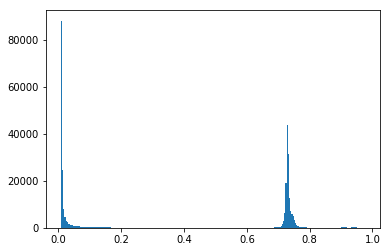

In [198]:
plt.figure()
plt.hist(img.ravel(), bins=256)
plt.show()

In [336]:
test = train.next()
X_Test = test[0][0:1]

Y_Test = test[1][0:1]
imgs_mask_test = autoencoder.predict_on_batch(X_Test)

AttributeError: 'numpy.ndarray' object has no attribute 'next'

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


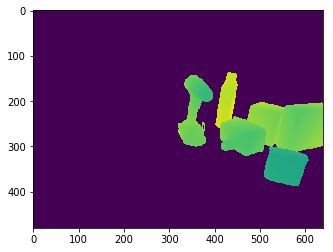

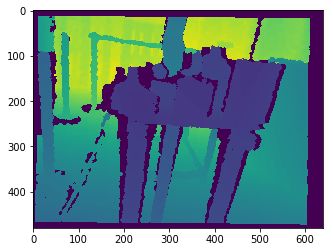

In [215]:
path = "/media/drc/DATA/chris_labelfusion/CORL2017/object_database/"
d_dir = os.listdir(path+"depth/")
gt_dir = os.listdir(path+"gtdepth/")
choice = np.random.randint(len(d_dir))
g= misc.imread(path+"gtdepth/"+gt_dir[choice])
d= misc.imread(path+"depth/"+d_dir[choice])
plt.imshow(g)
plt.figure()
plt.imshow(d)

In [216]:
g.max()

1081

In [142]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

NameError: name 'y_test' is not defined

In [311]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve

In [315]:
def test_on_set(test,model,size=1):
    data = np.zeros((1,480,640,1))
    pred = []
    targ = []
    prob = []
    for i in test[:size]:
        r = normalize(misc.imread(i[0]))
        r = np.reshape(r,(480,640,1))
        data[0] = r
        d = crop(hot_vectorize(misc.imread(i[1])))
        p = model.predict_on_batch(data)
        p = crop(p[0,:,:,0]).flatten()
        prob.extend(p)
        pred.extend(list((np.round(p).astype(int))))
        targ.extend(list(d.flatten().astype(int)))
    roc = roc_curve(targ,prob)
    plt.figure()
    plt.title("ROC curve for NDP prediction")
    plt.plot(roc[0],roc[1])
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    return (f1_score(targ,pred),roc)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


(0.627944416200644,
 (array([0.        , 0.        , 0.        , ..., 0.99401588, 0.99402977,
         1.        ]),
  array([6.26880642e-05, 1.24749248e-02, 1.26003009e-02, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
  array([9.9514741e-01, 9.9110246e-01, 9.9107790e-01, ..., 6.2720223e-06,
         6.2700069e-06, 1.7953365e-06], dtype=float32)))

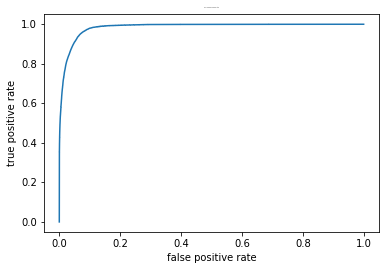

In [330]:
test_on_set(test,autoencoder)

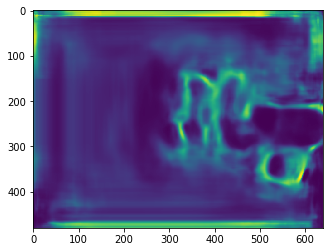

In [217]:
%matplotlib inline
gt = g/3000.
pred = autoencoder.predict_on_batch(np.reshape(gt,(1,480,640,1)))
plt.imshow(np.reshape(pred,(480,640)))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


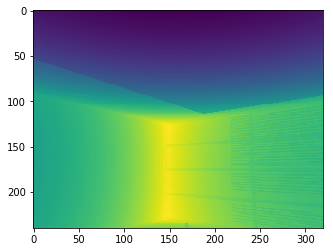

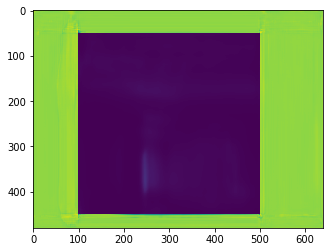

In [301]:
num = np.random.randint(999)
path  = "/media/drc/DATA/train/0/"+str(num)+"/depth/"
img_path = path+np.random.choice(os.listdir(path))
im = misc.imread(img_path)
%matplotlib inline
plt.figure()
plt.imshow(im)
plt.figure()
im = misc.imresize(im,(480,640))/255.
pred = autoencoder.predict_on_batch(np.reshape(im,(1,480,640,1)))
plt.imshow(np.reshape(pred,(480,640)))

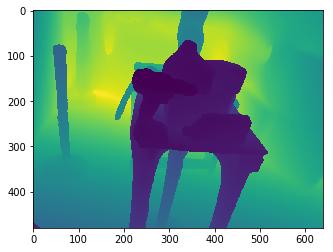

In [331]:
%matplotlib inline
img = np.reshape(X_Test[0],(480,640))
plt.imshow(img)

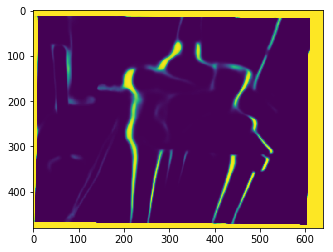

In [332]:
%matplotlib inline
img = np.reshape(imgs_mask_test[0],(480,640))
plt.imshow(img)

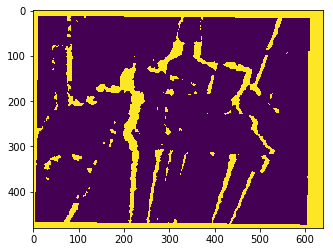

In [333]:
%matplotlib inline
img1 = np.reshape(Y_Test[0],(480,640))
plt.imshow(img1)

In [ ]:
img1 = np.copy(img)
img1[img1>.3] =1
plt.imshow(img1)